In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler, IterableDataset
import glob
from PIL import Image
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.notebook import trange

In [13]:
NUM_SHOTS = 6
NUM_WAYS = 20
BATCH_SIZE=32
NUM_ITER=100
EMBED_DIM=64
OMNIGLOT_FOLDER = "data/omniglot_resized/"

In [14]:
class Omniglot(IterableDataset):

    def __init__(self, num_shots, n_way, root="omniglot_resized/") -> None:
        super().__init__()
        self.num_shots = num_shots
        self.n_way = n_way
        self.filenames = glob.glob(root+"**/*.png", recursive=True)
        labels = [".".join(f.split("/")[-3:-1]) for f in self.filenames]
        class_names = list(set(labels))
        self.class_idx = np.arange(len(class_names))
        label_idx = np.array([class_names.index(label) for label in labels])
        self.images_per_class = []
        for i in self.class_idx:
            self.images_per_class.append((label_idx == i).nonzero()[0])

    def get_images(self, filename_idx):
        transform = ToTensor()
        images = torch.stack([transform(Image.open(self.filenames[id])) for id in filename_idx])
        return images
    
    def __iter__(self):
        while True:
            selected_classes = np.random.choice(self.class_idx, self.n_way)
            sel_images= []
            for i, cid in enumerate(selected_classes):
                c_images = self.get_images(np.random.choice(self.images_per_class[cid], self.num_shots))
                sel_images.append(c_images)
            sel_images = torch.stack(sel_images).transpose(0,1)
            yield sel_images


In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
)

In [5]:
dataset = Omniglot(NUM_SHOTS, NUM_WAYS, root=OMNIGLOT_FOLDER)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
dataloader_iter = iter(dataloader)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
tqiter = trange(100)
for i in tqiter:
    images = next(dataloader_iter)
    images = images.view(BATCH_SIZE*NUM_SHOTS*NUM_WAYS, 1,28,28).to(DEVICE)
    query_labels = torch.arange(NUM_WAYS).expand(BATCH_SIZE, NUM_WAYS).to(DEVICE) # BxN
    

    logits = model(images)
    logits = logits.view(BATCH_SIZE, NUM_SHOTS, NUM_WAYS, EMBED_DIM)
    support_logits = logits[:, :-1, :, :] # BxKxNxD
    query_logits = logits[:, -1, :, :] # Bx1xNxD
    
    
    prototypes = support_logits.mean(dim=1)
    query_dist = torch.cdist(query_logits, prototypes)
    loss = F.cross_entropy(-query_dist, query_labels)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    tqiter.set_postfix(loss=loss.item())   
    

  0%|          | 0/100 [00:00<?, ?it/s]

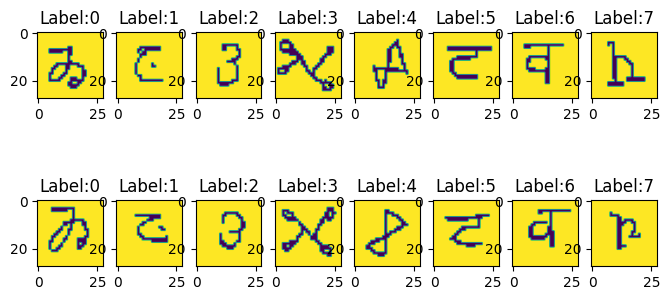

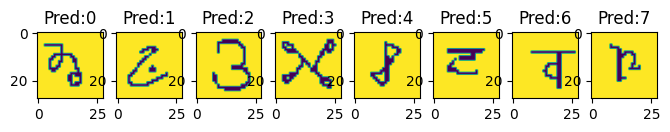

In [11]:
def plot_images(images, n_row, labels, title_prefix=""):
    n_col = images.shape[0] // n_row
    _, axs = plt.subplots(n_row, n_col, figsize=(8, 4))
    axs = axs.flatten()
    for i, (img, ax) in enumerate(zip(images, axs)):
        ax.imshow(img.permute(1,2,0))
        ax.set_title(f"{title_prefix}{labels[i]}")
    plt.show()

with torch.no_grad():
    num_query, num_ways = 3, 8
    images = next(iter(Omniglot(num_query,num_ways)))
    labels = torch.arange(num_ways).expand(num_query, num_ways).to(DEVICE)

    logits = model(images.reshape(num_ways*num_query, 1,28,28).to(DEVICE))
    logits = logits.view(num_query, num_ways,-1)

    support_logits = logits[:-1]
    query_logits = logits[-1]

    prototypes = support_logits.mean(0)
    dists = torch.cdist(query_logits, prototypes)
    preds = torch.argmin(dists, dim=1).cpu()
    
    plot_images(images[:-1].reshape(-1,1,28,28), 2, labels[:-1].flatten(), title_prefix="Label:")
    plot_images(images[-1].reshape(-1, 1, 28, 28), 1, preds, title_prefix="Pred:")